# Denoising Diffusion Implicit Models - DDIM

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.fid import *

In [2]:
from fastprogress.fastprogress import progress_bar

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

README.md: 0.00B [00:00, ?B/s]

fashion_mnist/train-00000-of-00001.parqu(…):   0%|          | 0.00/30.9M [00:00<?, ?B/s]

fashion_mnist/test-00000-of-00001.parque(…):   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

## Diffusers DDPM Scheduler

In [6]:
class UNet(UNet2DModel): pass

In [7]:
model = torch.load('models/fashion_ddpm3_25.pkl').cuda()
# model = torch.load('models/fashion_no-t.pkl').cuda()

/tmp/ipykernel_3159/2636898039.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/fashion_ddpm3_25.pkl').cuda()


In [8]:
sched = DDPMScheduler(beta_end=0.01)

In [9]:
x_t = torch.randn((32,1,32,32)).cuda()

In [10]:
t = 999
t_batch = torch.full((len(x_t),), t, device=x_t.device, dtype=torch.long)
with torch.no_grad(): noise = model(x_t, t_batch).sample

In [11]:
res = sched.step(noise, t, x_t)

In [12]:
res.prev_sample.shape

torch.Size([32, 1, 32, 32])

In [13]:
sz = (2048,1,32,32)

In [14]:
%%time
x_t = torch.randn(sz).cuda()
preds = []

for t in progress_bar(sched.timesteps):
    with torch.no_grad(): noise = model(x_t, t).sample
    x_t = sched.step(noise, t, x_t).prev_sample
    preds.append(x_t.float().cpu())

CPU times: user 24min 34s, sys: 6.55 s, total: 24min 40s
Wall time: 24min 43s


In [15]:
s = preds[-1].clamp(-0.5,0.5)*2

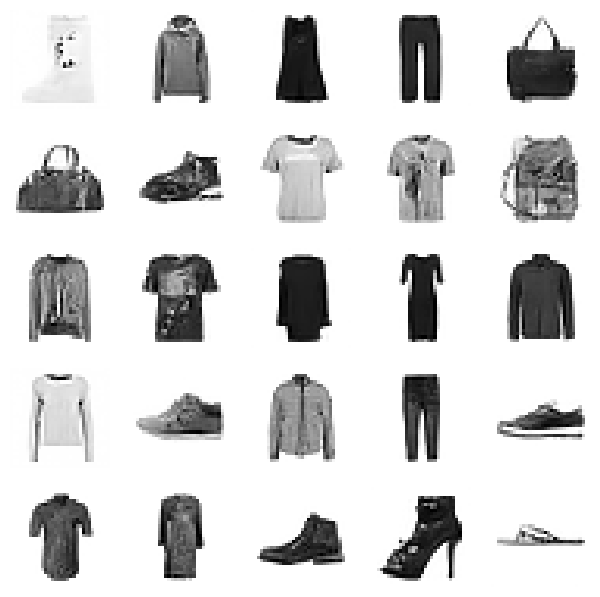

In [16]:
show_images(s[:25], imsize=1.5)

In [17]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

/tmp/ipykernel_3159/1865695266.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load('models/data_aug2.pkl')


In [18]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb,yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [19]:
ie.fid(s),ie.kid(s)

(4.9388427734375, 0.031142583116889)

In [20]:
ie.fid(xb),ie.kid(xb)

(1.5965576171875, 0.03602418676018715)

## Diffusers DDIM Scheduler

In [21]:
sched = DDIMScheduler(beta_end=0.01)
sched.set_timesteps(333)

In [22]:
def diff_sample(model, sz, sched, **kwargs):
    x_t = torch.randn(sz).cuda()
    preds = []
    for t in progress_bar(sched.timesteps):
        with torch.no_grad(): noise = model(x_t, t).sample
        x_t = sched.step(noise, t, x_t, **kwargs).prev_sample
        preds.append(x_t.float().cpu())
    return preds

In [23]:
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)

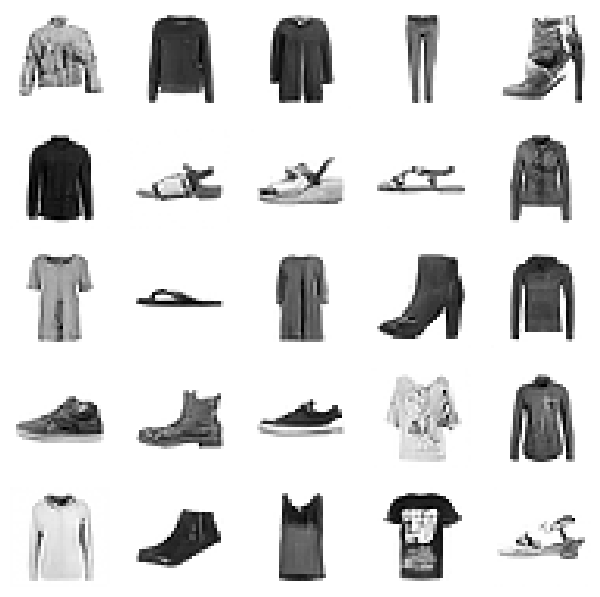

In [24]:
show_images(s[:25], imsize=1.5)

In [25]:
ie.fid(s),ie.kid(s)

(5.3934326171875, 0.043168243020772934)

In [26]:
sched.set_timesteps(200)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(7.3968505859375, 0.040143512189388275)

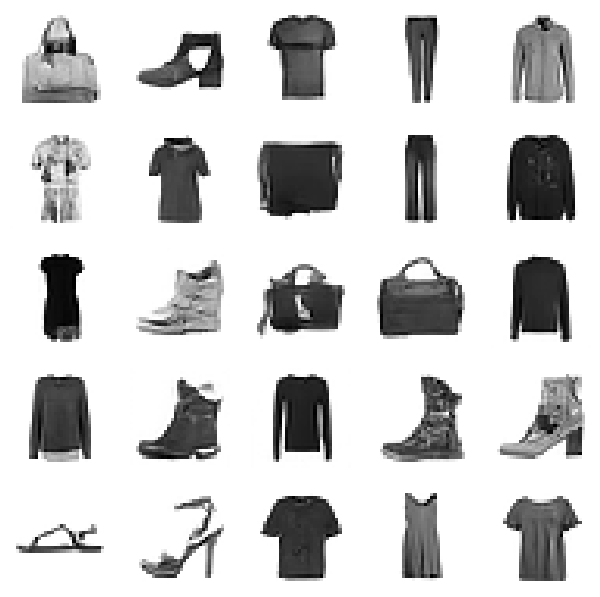

In [27]:
show_images(s[:25], imsize=1.5)

In [28]:
sched.set_timesteps(100)
preds = diff_sample(model, sz, sched, eta=1.)

In [29]:
s = (preds[-1]*2).clamp(-1,1)

In [30]:
ie.fid(s),ie.kid(s)

(13.463134765625, 0.11075937747955322)

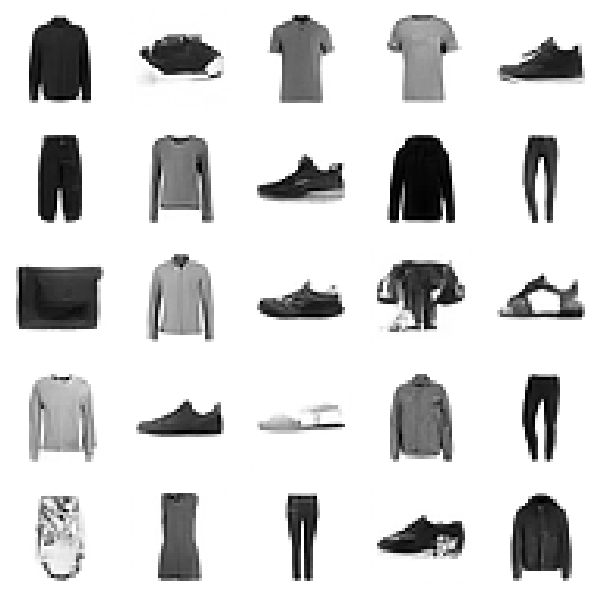

In [31]:
show_images(s[:25], imsize=1.5)

In [32]:
sched.set_timesteps(50)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(17.8046875, 0.13128983974456787)

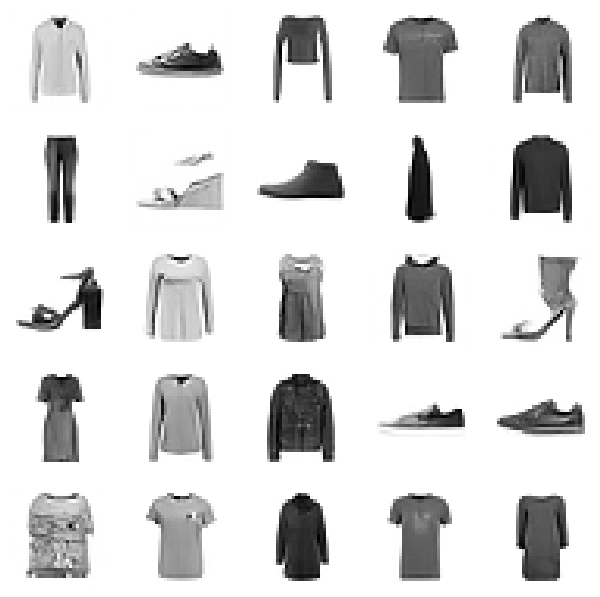

In [33]:
show_images(s[:25], imsize=1.5)

In [34]:
sched.set_timesteps(25)
preds = diff_sample(model, sz, sched, eta=1.)
s = (preds[-1]*2).clamp(-1,1)
ie.fid(s),ie.kid(s)

(37.9398193359375, 0.24334828555583954)

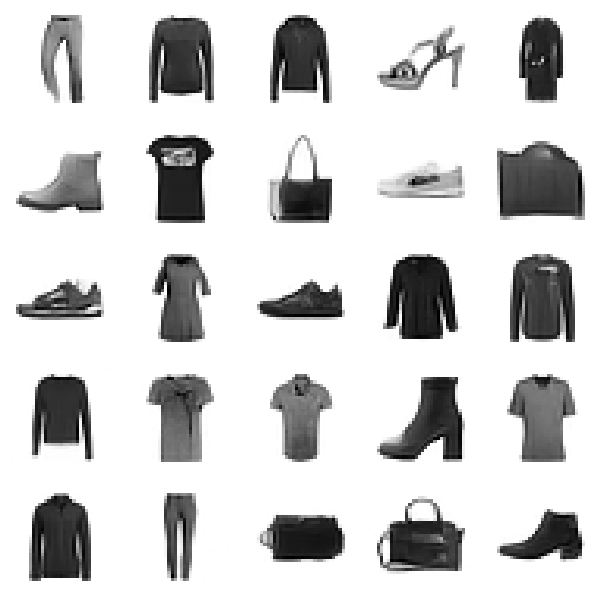

In [35]:
show_images(s[:25], imsize=1.5)

## Implementing DDIM

In [36]:
from types import SimpleNamespace

In [37]:
n_steps=1000

In [38]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [39]:
sc = linear_sched(betamax=0.01, n_steps=n_steps)
abar = sc.abar

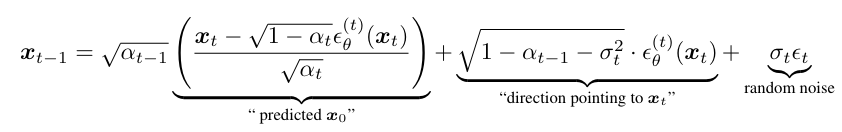

In [40]:
def ddim_step(x_t, t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta):
    vari = ((bbar_t1/bbar_t) * (1-abar_t/abar_t1))
    sig = vari.sqrt()*eta
    x_0_hat = ((x_t-bbar_t.sqrt()*noise) / abar_t.sqrt())
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    if t>0: x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_t

In [41]:
@torch.no_grad()
def sample(f, model, sz, n_steps, skips=1, eta=1.):
    tsteps = list(reversed(range(0, n_steps, skips)))
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i,t in enumerate(progress_bar(tsteps)):
        abar_t1 = abar[tsteps[i+1]] if t > 0 else torch.tensor(1)
        noise = model(x_t,t).sample
        x_t = f(x_t, t, noise, abar[t], abar_t1, 1-abar[t], 1-abar_t1, eta)
        preds.append(x_t.float().cpu())
    return preds

In [42]:
%%time
samples = sample(ddim_step, model, sz, 1000, 10)

CPU times: user 2min 47s, sys: 174 ms, total: 2min 47s
Wall time: 2min 47s


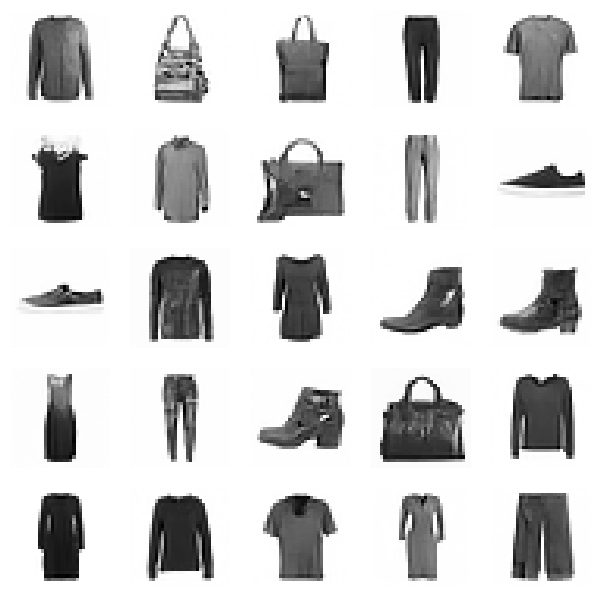

In [43]:
s = (samples[-1]*2)#.clamp(-1,1)
show_images(s[:25], imsize=1.5)

In [44]:
ie.fid(s),ie.kid(s)

(12.598876953125, 0.06747859716415405)

## Triangular noise

In [45]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    t = np.random.triangular(0, 0.5, 1, (n,))*n_steps
    t = tensor(t, dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

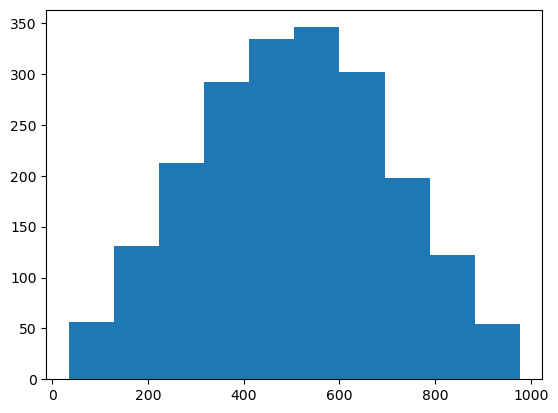

In [46]:
(xt,t),ε = noisify(xb,abar)
plt.hist(t);